# Solve with GLUE
*R.A. Collenteur, University of Graz*



In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pastas as ps
from pastas.stats import nse, kge_2012

ps.set_log_level("ERROR")

In [4]:
# read observations and create the time series model and make meters
obs = pd.read_csv("../data/B32C0639001.csv", parse_dates=['date'],
                  index_col='date', squeeze=True)

# Create the time series model
ml = ps.Model(obs, name="head")

# read weather data and make mm/d !
evap = ps.read_knmi("../data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("../data/etmgeg_260.txt", variables="RH").series * 1e3

# Initialize recharge model and create stressmodel
rch = ps.rch.FlexModel()
# rch = ps.rch.Berendrecht()
# rch = ps.rch.Linear()
sm = ps.RechargeModel(prec=rain, evap=evap, rfunc=ps.Exponential, recharge=rch)

ml.add_stressmodel(sm)

ml.solve(noise=True, tmin="1990")

Fit report head                        Fit Statistics
nfev    31                     EVP           84.92
nobs    351                    R2             0.85
noise   1                      RMSE           0.08
tmin    1990-01-01 00:00:00    AIC           88.53
tmax    2005-10-14 00:00:00    BIC          115.55
freq    D                      Obj            0.62
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (7 optimized)
                  optimal   stderr     initial   vary
recharge_A       0.300672   ±5.39%    0.721210   True
recharge_a      88.071264   ±6.42%   10.000000   True
recharge_srmax  53.344518   ±3.60%  250.000000   True
recharge_lp      0.250000    ±nan%    0.250000  False
recharge_ks     62.803784   ±8.20%  100.000000   True
recharge_gamma   5.761574   ±6.30%    4.000000   True
recharge_simax   2.000000    ±nan%    2.000000  False
recharge_kv      1.000000    ±nan%    1.000000  False
constant_d       0.949780 

In [6]:
def target(p):
    obs = ml.observations()
    sim = ml.simulate(p=p)
    return nse(obs=obs, sim=sim)

In [25]:
# Solve
for param in ml.parameters.index:
    ml.set_parameter(param, vary=False)

ml.set_parameter("recharge_ks", pmax=2000, vary=True)
ml.set_parameter("recharge_srmax", vary=True)

Fit report head                     Fit Statistics
nfev    50000                  EVP           74.49
nobs    544                    R2             0.74
noise   0                      RMSE           0.10
tmin    1981-07-03 00:00:00    AIC          963.45
tmax    2005-10-14 00:00:00    BIC          972.05
freq    D                      Obj            0.74
warmup  3650 days 00:00:00     ___                
solver  MonteCarlo             Interp.          No

Parameters (2 optimized)
                  optimal stderr    initial   vary
recharge_A       0.300672  ±nan%   0.300672  False
recharge_a      88.071264  ±nan%  88.071264  False
recharge_srmax  35.074867  ±nan%  32.165989   True
recharge_lp      0.250000  ±nan%   0.250000  False
recharge_ks     43.796622  ±nan%  36.444981   True
recharge_gamma   5.761574  ±nan%   5.761574  False
recharge_simax   2.000000  ±nan%   2.000000  False
recharge_kv      1.000000  ±nan%   1.000000  False
constant_d       0.949780  ±nan%   0.949780  False


<AxesSubplot:title={'center':'Results of head'}, ylabel='Groundwater levels [meter]'>

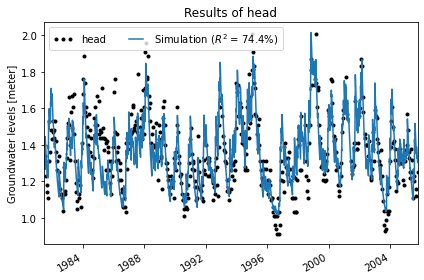

In [26]:
ml.solve(solver=ps.GlueSolver, target=target, n=int(5e4), noise=False,
         initial=False)
ml.plot()

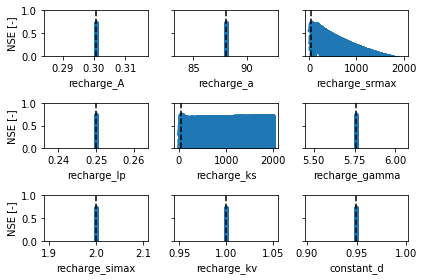

In [27]:
fig, axes = plt.subplots(3, 3, sharey=True)
axes = axes.flatten()
for i, (name, par) in enumerate(ml.fit.parameters.iteritems()):
    axes[i].plot(par, ml.fit.obj, marker=".", linestyle=' ')
    axes[i].set_xlabel(name)
    axes[i].axvline(ml.parameters.loc[name, "optimal"], color="k",
                    linestyle="--")
for i in range(0, 9, 3):
    axes[i].set_ylabel("NSE [-]")
axes[-1].set_ylim(0, 1)
plt.tight_layout()

Text(0, 0.5, 'recharge_srmax')

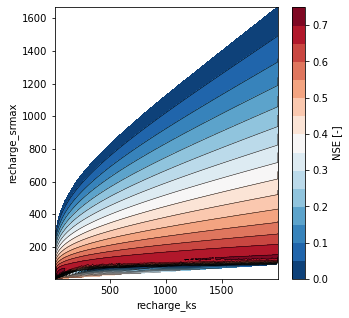

In [28]:
# Contour plot of the parameter landscape
x = ml.fit.parameters.recharge_ks[ml.fit.obj>-0]
y = ml.fit.parameters.recharge_srmax[ml.fit.obj>-0]
z = ml.fit.obj[ml.fit.obj > -0]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
cb = fig.colorbar(cntr, ax=ax, label="NSE [-]")
ax.set_xlabel(x.name)
ax.set_ylabel(y.name)

<AxesSubplot:title={'center':'Results of head'}, ylabel='Groundwater levels [meter]'>

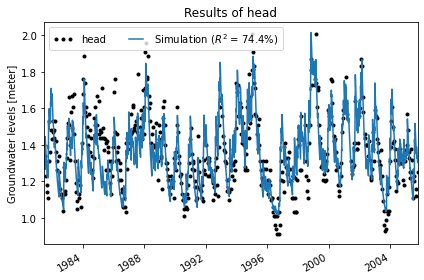

In [29]:
ml.plot()